In [1]:
from scipy.stats import pearsonr
from scipy import stats
import os, subprocess, sys, mygene, string, glob, tqdm

def rank_push (input_adata, groupby, prefix, wkdir, s3dir, methods=['wilcoxon','t-test_overestim_var']):
    
    if len(methods) != 2:
        print('requires exactly 2 methods')
    else:
    
        rank_df = rank_genes(input_adata, 
                             methods=methods,
                             groupby=groupby)

        # inner join 2 methods 
        input_rank = rank_df
        joined_test = pd.merge(input_rank[input_rank['method'] == methods[0]]
                               .reset_index()
                               .rename(columns={'index':'{}_rank'.format(methods[0])})
                               .drop(columns='method', axis=1),
                             input_rank[input_rank['method'] == methods[1]]
                               .reset_index()
                               .rename(columns={'index':'{}_rank'.format(methods[1])})
                               .loc[:,['gene',groupby,'{}_rank'.format(methods[1])]],
                             'inner',
                             ['gene',groupby])

        # push to s3
        push_rank (rank_df, f'{prefix}_full', wkdir, s3dir)
        push_rank (joined_test, f'{prefix}_joined', wkdir, s3dir)
    
        return rank_df, joined_test
    
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

def symbol2field(genelist, field='summary',species='human'):
    # wrapper around mygene query
    # genelist = list of str gene symbols
    mg = mygene.MyGeneInfo()
    xli = genelist
    out = mg.querymany(xli, scopes='symbol', fields='summary', species=species)
    return out

def gene2plots(input_adata, gene, groupby, ordered_list):

    cats, casted_df = prepare_dataframe(input_adata, 
                                         gene, 
                                         groupby=groupby)

    melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)
    melt_df[f'{groupby}_cat'] = melt_df[groupby].astype(str).astype(CategoricalDtype(ordered_list, ordered=True))

    plotnine.options.figure_size = (4,4)
    print(ggplot(melt_df,aes(f'{groupby}_cat','value',color=f'{groupby}_cat'))
                  +theme_bw()
                  +theme(aspect_ratio=1,
                        axis_text_x=element_text(angle=90))
                  +geom_boxplot()
                  +stat_summary(aes(group=1), fun_y=np.median, geom='line',color='black')
                  +labs(y='log expression', x=''))

    # % of cells expressing CDKN2A
    cell_counts_df = casted_df.reset_index().groupby(groupby).describe().reset_index()
    gene_binary_df = casted_df[casted_df[gene] > 0].reset_index().groupby(groupby).describe().reset_index()

    df = pd.merge(gene_binary_df, cell_counts_df, 'left', groupby)
    df['prob'] = df[(f'{gene}_x','count')] /df[(f'{gene}_y','count')]
    df[f'{groupby}_cat'] = df[groupby].astype(str).astype(CategoricalDtype(ordered_list, ordered=True))
    print(ggplot(df.loc[:,[f'{groupby}_cat','prob']])
                +theme_bw()
          +theme(aspect_ratio=1,
                axis_text_x=element_text(angle=90))
          +geom_line(aes(f'{groupby}_cat','prob',group=1))
          +geom_point(aes(f'{groupby}_cat','prob',color=f'{groupby}_cat'))
          +labs(y='proportion of cells expressing', x=''))
    
def txn_noise(input_adata, groupby, pre_adata):
    # Calculates transcription noise as defined by https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6047899/
    # Updates adata obj inplace with new noise columns for each cell
    # Input: pre_adata (raw counts table), adata obj, groupby str that identifies categorical metadata field to define group reference
    # Output: extracted metadata table for plotting and post analysis

    groups=list(set(input_adata.obs[groupby].values))
    
    # process raw counts table to extract ERCC counts per cell
    ercc_df = (pre_adata
                   .reset_index()
                   .rename(columns = {'gene_name':'gene'}))
    ercc_names = [x for x in ercc_df['gene'] if 'ERCC-' in x]
    ercc_df_T = (ercc_df
                 .set_index('gene')
                 .T
                 .reset_index()
                 .rename(columns={'index':'cell'}))
    ercc_df_T.columns = (ercc_df_T
                         .columns
                         .get_level_values(0))

    # FOR GENES: preprocess adata obj to calculate group-wise mean expression
    means_df = (pd.merge((input_adata
                         .obs[groupby]
                         .reset_index()
                         .rename(columns={'index':'cell'})),
                        (ercc_df_T
                         .loc[:,[x for x in ercc_df_T.columns if not 'ERCC-' in x]]),
                        'left',
                        'cell')
                .groupby(groupby)
                .mean()
                .T)
    means_df.columns = [f'group_{x}' for x in means_df.columns]
    means_df = (means_df
                .reset_index()
                .rename(columns={'index':'gene'}))
    
    # FOR ERCC: preprocess adata obj to calculate group-wise mean expression 
    means_df_ercc = (pd.merge((input_adata
                              .obs[groupby]
                              .reset_index()
                              .rename(columns={'index':'cell'})),
                        (ercc_df_T
                         .loc[:,['cell']+[x for x in ercc_df_T.columns if 'ERCC-' in x]]),
                        'left',
                        'cell')
                     .groupby(groupby)
                     .mean()
                     .T)
    means_df_ercc.columns = [f'group_ercc_{x}' for x in means_df_ercc.columns]
    means_df_ercc = (means_df_ercc
                     .reset_index()
                     .rename(columns={'index':'gene'}))
    
    # Merge respective tables => ready for correlations
    merge_df = pd.merge(means_df, ercc_df,'left','gene')
    merge_df_ercc = pd.merge(means_df_ercc, ercc_df,'left','gene')

    # Groupby-matched Pearson correlations
    return_df = pd.DataFrame()
    for dataset in [merge_df, merge_df_ercc]:
        dat = (dataset.drop('gene',axis=1))
        refs = [x for x in dat.columns.tolist() if x.startswith('group')]
        i_list = [x for x in dat.columns.tolist() if not x.startswith('group')]

        for ref in refs:
            r_list = []
            for col in i_list:
                try:
                    df = dat[[ref,col]]
                    df = df.dropna()._get_numeric_data()
                    r, pval = pearsonr(df[ref], df[col])
                except:
                    r, pval = np.nan, np.nan

                r_list.append(r)
            out_df = pd.DataFrame({ref:r_list})
            return_df = pd.concat([return_df, out_df], axis=1)
            
    # add cell id
    return_df['cell'] = i_list
    return_df = pd.merge((input_adata
                          .obs[groupby]
                          .reset_index()
                          .drop(groupby,axis=1)
                          .rename(columns={'index':'cell'})),
                     return_df,
                     'left','cell')
    
    # update adata obj
    for x in groups:
        return_df[f'noise_{x}'] = (1-return_df[f'group_{x}'])/(1-return_df[f'group_ercc_{x}'])
        input_adata.obs[f'noise_{x}'] = [j if i == x else np.nan for i,j in zip(input_adata.obs[groupby].tolist(),
                                                                                return_df[f'noise_{x}'].tolist())]
    
    return input_adata
    
def s3_crawler(plate_list, s3dir_df, manual_filter = False):
    # Look for plate_ids in s3 seqbot dirs
    # Input: plate list
    # Output: compiled dataframe for all matching cell_plate_idx counts tables
    
    #! aws s3 ls s3://czbiohub-seqbot --recursive | awk '{print "s3://czbiohub-seqbot/"$4}' > DL20190114_czbiohubseqbot.txt
    #! aws s3 ls s3://czb-seqbot --recursive | awk '{print "s3://czb-seqbot/"$4}' > DL20190114_czbseqbot.txt
    #! for i in DL20190114_czbseqbot.txt DL20190114_czbiohubseqbot.txt; do aws s3 cp $i s3://daniel.le-work/MEL_project/; done

    # filter to only counts tables that match plate id

    plate_dfs = pd.DataFrame()
    for plate_id in plate_list:
        
        # parse path
        paths = [x for x in s3dir_df.paths if plate_id in x]
        fname = [x.split('/')[-1] for x in paths]
        cell = ['_'.join(x.split('_')[:2]) for x in fname]
        df = pd.DataFrame({'paths':paths,
                          'fname':fname,
                          'cell':cell})
        df = pd.merge(pd.DataFrame({'cell':df['cell'].value_counts().index}),df,'left','cell')
        df['idx'] = [y for x in df['cell'].value_counts() for y in range(x)]
        df['plate'] = plate_id
        redundant_names = [x > 1 for x in df['cell'].value_counts()]
        
        # remove redundant module
        print('{} pre-filter redundant names'.format(sum(redundant_names)))
        while manual_filter is True and any(redundant_names):
            for path in df.loc[df.cell == df['cell'].value_counts().index[0]].paths:
                print(path)
            print('Input parent s3 path that contains all samples to keep')
            parent_path = input()
            df = df[[x.startswith(parent_path) for x in df.paths]]
            redundant_names = [x > 1 for x in df['cell'].value_counts()]
        plate_dfs = plate_dfs.append(df)
        print('Plate {} has {}/{} redundant names'.format(plate_id,
                                                          sum([x > 0 for x in df.idx]),
                                                          len(df)))
    print('Found {} samples in {} plates'.format(len(plate_dfs),
                                                len(set(plate_dfs.plate))))

    return plate_dfs

def pulls3(args):
    # Parallizable pull s3 data
    path, plate, fname, wdkir = args
    curr_dir = f'{wkdir}/tmp/{plate}'
        
    if not os.path.exists(f'{curr_dir}/{fname}'):
        if not os.path.exists(curr_dir):
            os.mkdir(curr_dir)
    
        cmd = f'aws s3 cp {path} {curr_dir}/'
        subprocess.run(cmd.split(' '))

def merge_counts(top_dir):
    # Create big counts table from local tables
    file_list = [filename for filename in glob.iglob(top_dir + '**/*.txt', recursive=True)]
    first_df = pd.read_csv(file_list[0], header=None, delimiter='\t')
    num_row = len(first_df)
    rownames = first_df.iloc[:,0].tolist()
    num_col = len(file_list)
    colnames = []
    empty_array = np.zeros((num_row, num_col))
    
    for idx, file in tqdm.tqdm(enumerate(file_list)):
        pulled_col = pd.read_csv(file, header=None, delimiter='\t', usecols=[1])
        colname = '_'.join(file.split('/')[-1].split('_')[:2] + ['0'])
        if colname in colnames:
            name_split = colname.split('_')
            new_idx =  int(name_split[-1]) + 1
            colname = '_'.join(name_split[:2] + [new_idx])
        colnames.append(colname)
        empty_array[:,idx] = pulled_col.values.reshape((len(pulled_col),))
    
    # convert numpy to pandas
    master_df = pd.DataFrame(empty_array)
    master_df.columns = colnames
    master_df['gene'] = rownames
    
    # remove metadata 
    master_df = master_df[["__" not in x for x in master_df.gene]]
    
    # reset gene col
    master_df = master_df.set_index('gene').reset_index()
    
    return master_df
    


# Setup

In [2]:
# settings
%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_mel_metadata.csv')
meta_df = meta_df.drop(['seq_run', 
                        'GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

# add bsc data:
bsc = pd.read_csv('s3://daniel.le-work/MEL_project/DL20181106_bsc_metadata.csv')
merged_anno = pd.merge(meta_df,bsc,'left',['well','plate_barcode'])

# filter merged annotations
merged_anno = merged_anno[[x in cell_names for x in merged_anno.cell_name]]
merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), merged_anno, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')

# markers
markers = ['PMEL','KRT1','KRT5','KRT10','TYR','MITF']

scanpy version: 1.3.3


# Ingest data protocol
- Raw data and annotation CSV provided by Ashley Maynard

In [3]:
raw_adata = create_adata(pre_adata)
raw_adata.var['ribo'] = raw_adata.var_names.str.startswith(('RPL','RPS'))
raw_adata.var['ercc'] = np.array([True if 'ERCC' in x else False for x in raw_adata.var_names.tolist()])
sc.pp.calculate_qc_metrics(raw_adata, feature_controls=['ribo','ercc'], inplace=True)
anno_dict = {'age':'age',
             'age_bin':'age_bin',
             'plate':'plate_barcode',
             'general_location':'general_location',
             'anatomical_location':'anatomical_location',
             'race':'race',
             'sex':'sex',
             'color':'sample_color',
             'patient':'patient_id',
             'bsc': 'bsc_a'}
append_anno(raw_adata, merged_anno, anno_dict)
append_markers(raw_adata, gene_markers=markers)
technical_filters(raw_adata)
raw_adata = remove_ercc(raw_adata) 
raw_adata.raw = sc.pp.log1p(raw_adata, copy=True) # freeze raw state

Ingest raw data...
	Cells: 8051, Genes: 26577
Append annotations...
	Cells: 8051, Genes: 26577
Append marker gene expresssion...
Remove low-quality cells/genes...
	Initial:
	Cells: 8051, Genes: 26577
	Result:
	Cells: 5911, Genes: 23870
Remove ERCC genes...
Filtered genes: 87
	Cells: 5911, Genes: 23783


# All-cells analysis

Process expression data...
	Initial:
	Cells: 5911, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13414
	Result:
	Cells: 5911, Genes: 10369
Principle component analysis...


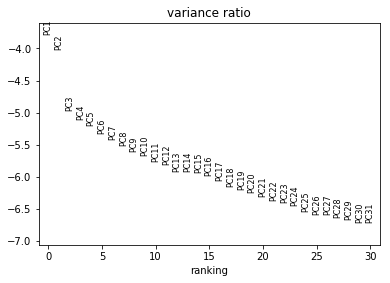

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


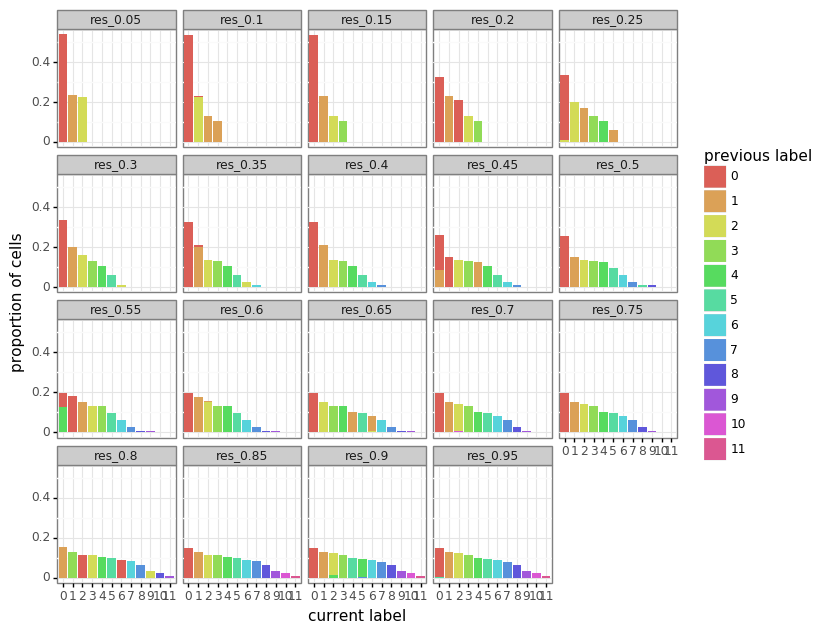

<ggplot: (8769245026603)>


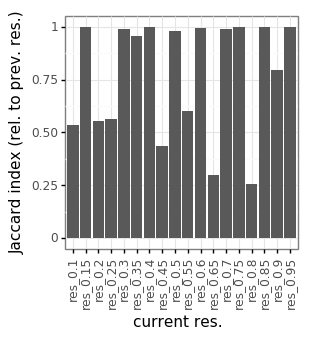

<ggplot: (8769239855957)>
resolution(res): 0.25


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical


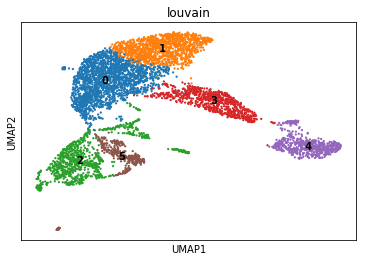

In [4]:
full_adata = process_adata(raw_adata)
pca_adata(full_adata, num_pcs=30)
umap_adata(full_adata, res=0.25)

# Classify MEL vs KRT
- Manual classification based on marker gene expression

In [5]:
# classify in raw adata
input_adata = full_adata

MEL_int = [0,1,3,4]
KRT_int = [x for x in range(len(input_adata.obs['louvain'].cat.categories)) if x not in MEL_int]
type_dict = {'KRT':[str(x) for x in KRT_int],
             'MEL':[str(x) for x in MEL_int]}
    
classify_type(raw_adata, input_adata, 'louvain', type_dict, 'class_1')

# MEL only re-cluster

key = class_1, value = MEL, matched = 4561
	Cells: 4561, Genes: 23783
Process expression data...
	Initial:
	Cells: 4561, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13610
	Result:
	Cells: 4561, Genes: 10173
Principle component analysis...


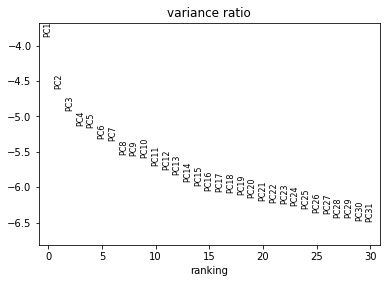

principle_components(num_pcs): 30
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


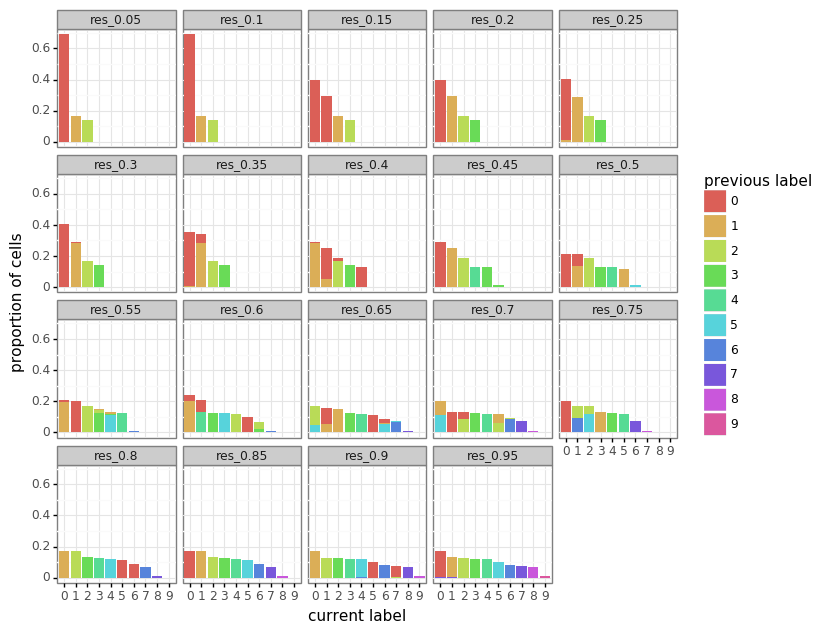

<ggplot: (-9223363267618831486)>


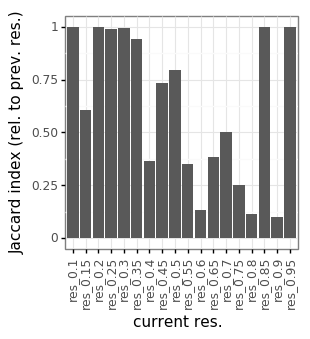

<ggplot: (8769239846990)>
resolution(res): 0.15


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical


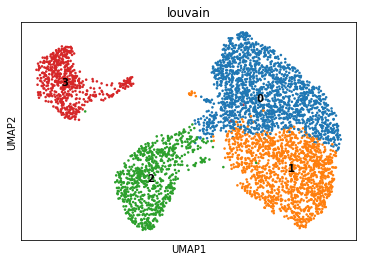

In [6]:
# MEL only

feature_dict = {'class_1':['MEL']}
adata_subset1 = subset_adata_v3(raw_adata,feature_dict)
adata_subset1 = process_adata(adata_subset1)
pca_adata(adata_subset1, num_pcs=30)
umap_adata(adata_subset1, res=0.15)

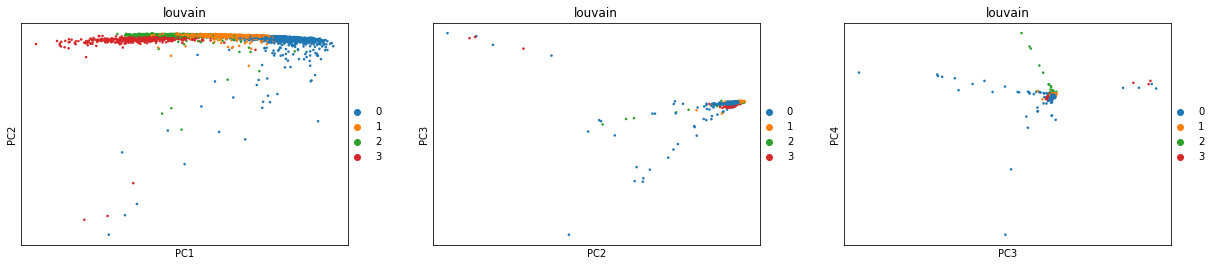

Filtered cells:  278


... storing 'outliers' as categorical


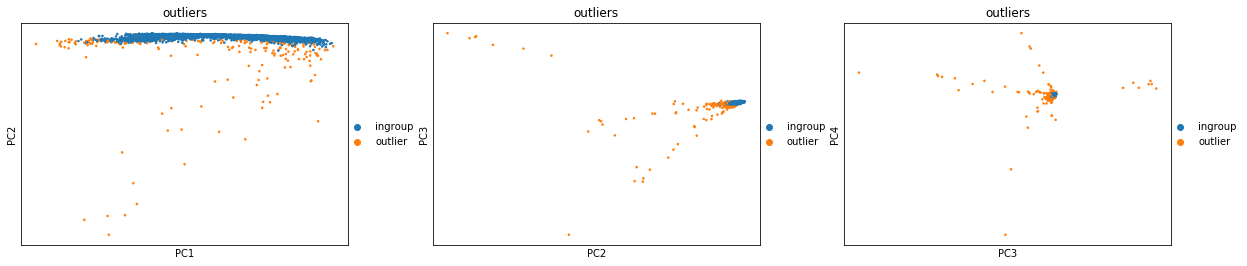

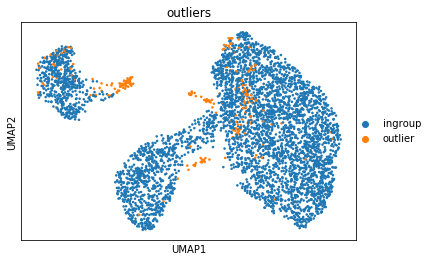

... storing 'outliers' as categorical


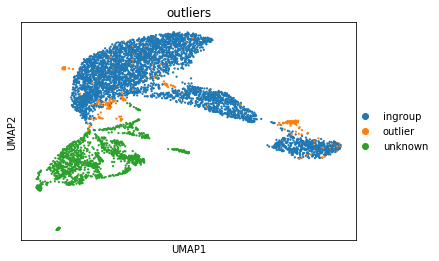

In [7]:
# initial PC coordinates
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['louvain'])

# cull cells using Tukey outlier threshold
df = pd.DataFrame(adata_subset1.obsm['X_pca'])
df.columns = ['PC_{}'.format(x) for x in range(50)]

omit_names = []
for pc in df.columns:
#     print(len(set(omit_names)))
    Q1 = df[pc].quantile(0.25)
    Q3 = df[pc].quantile(0.75)
    IQR = Q3 - Q1
    threshold=5

    bool_idx = [True if ((Q1 - threshold * IQR) <= x <= (Q3 + threshold * IQR)) else False for x in df[pc]]
    filtered = df[bool_idx]
#     print('Filtered cells: ', len(df)-len(filtered))
    
    omit_names = omit_names + adata_subset1.obs[[not x for x in bool_idx]].index.tolist()

print('Filtered cells: ', len(set(omit_names)))
test = raw_adata[[x for x in raw_adata.obs.index if x not in set(omit_names)]]

# check where the outliers lie in original projection
input_adata = adata_subset1
input_adata.obs['outliers'] = ['outlier' if x in set(omit_names) else 'ingroup' for x in input_adata.obs.index]

# outliers among adt-mels
sc.pl.pca(adata_subset1, components=['1,2', '2,3','3,4'], color=['outliers'])
sc.pl.umap(input_adata, color=['outliers'], cmap='magma')

# outliers on all-cells projection
input_adata = adata_subset1

type_dict = {'ingroup':['ingroup'],
             'outlier':['outlier']}
    
classify_type(full_adata, input_adata, 'outliers', type_dict, 'outliers')

sc.pl.umap(full_adata, color=['outliers'])

key = class_2, value = in, matched = 4283
	Cells: 4283, Genes: 23783
Process expression data...
	Initial:
	Cells: 4283, Genes: 23783
min mean expression (min_mean): 0.0125
max mean expression (max_mean)): 10
min dispresion (min_disp): 0.1
Filtered cells: 0
Filtered genes: 13356
	Result:
	Cells: 4283, Genes: 10427
Principle component analysis...


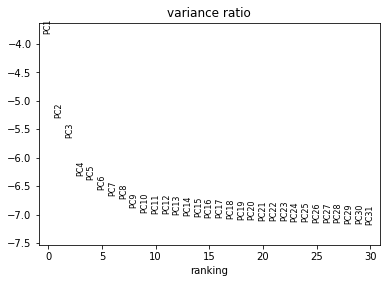

principle_components(num_pcs): 10
cells/neighborhood(hoods): 30
Uniform manifold approximation and projection...
	Scan Louvain detection resolutions
	resolution_interval(step_size): 0.05


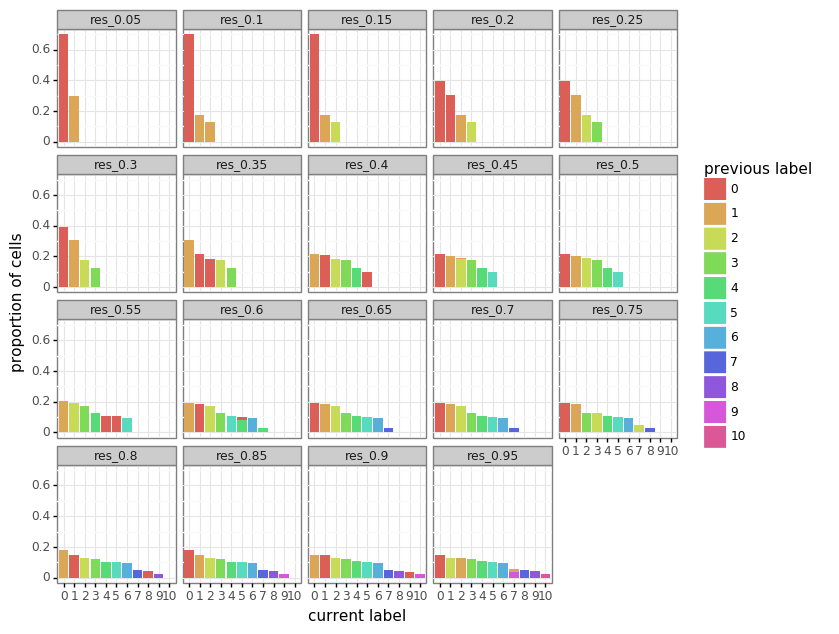

<ggplot: (-9223363267615615544)>


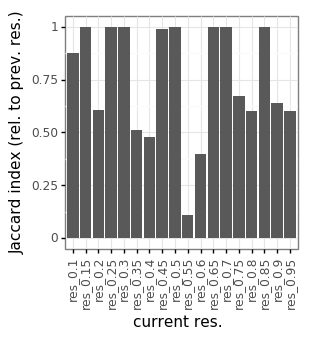

<ggplot: (-9223363267608829973)>
resolution(res): 0.35


... storing 'age_bin' as categorical
... storing 'plate' as categorical
... storing 'general_location' as categorical
... storing 'anatomical_location' as categorical
... storing 'race' as categorical
... storing 'sex' as categorical
... storing 'color' as categorical
... storing 'patient' as categorical
... storing 'class_1' as categorical
... storing 'class_2' as categorical


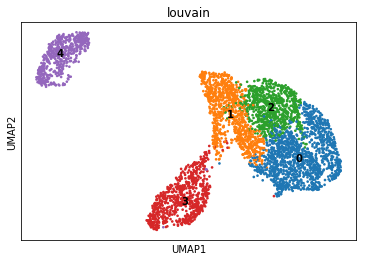

In [8]:
# classify in raw adata
input_adata = adata_subset1

type_dict = {'in':['ingroup'],
             'out':['outlier']}
    
classify_type(raw_adata, input_adata, 'outliers', type_dict, 'class_2')

feature_dict = {'class_2':['in']}
adata_subset2 = subset_adata_v3(raw_adata,feature_dict)
adata_subset2 = process_adata(adata_subset2)
pca_adata(adata_subset2, num_pcs=10)
umap_adata(adata_subset2, res=0.35)

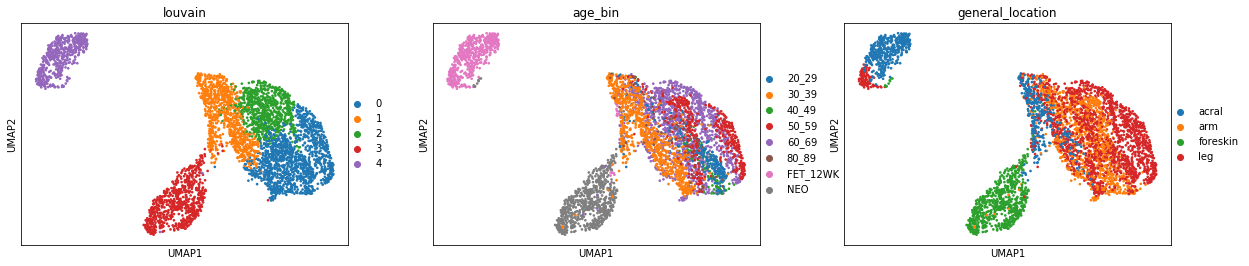

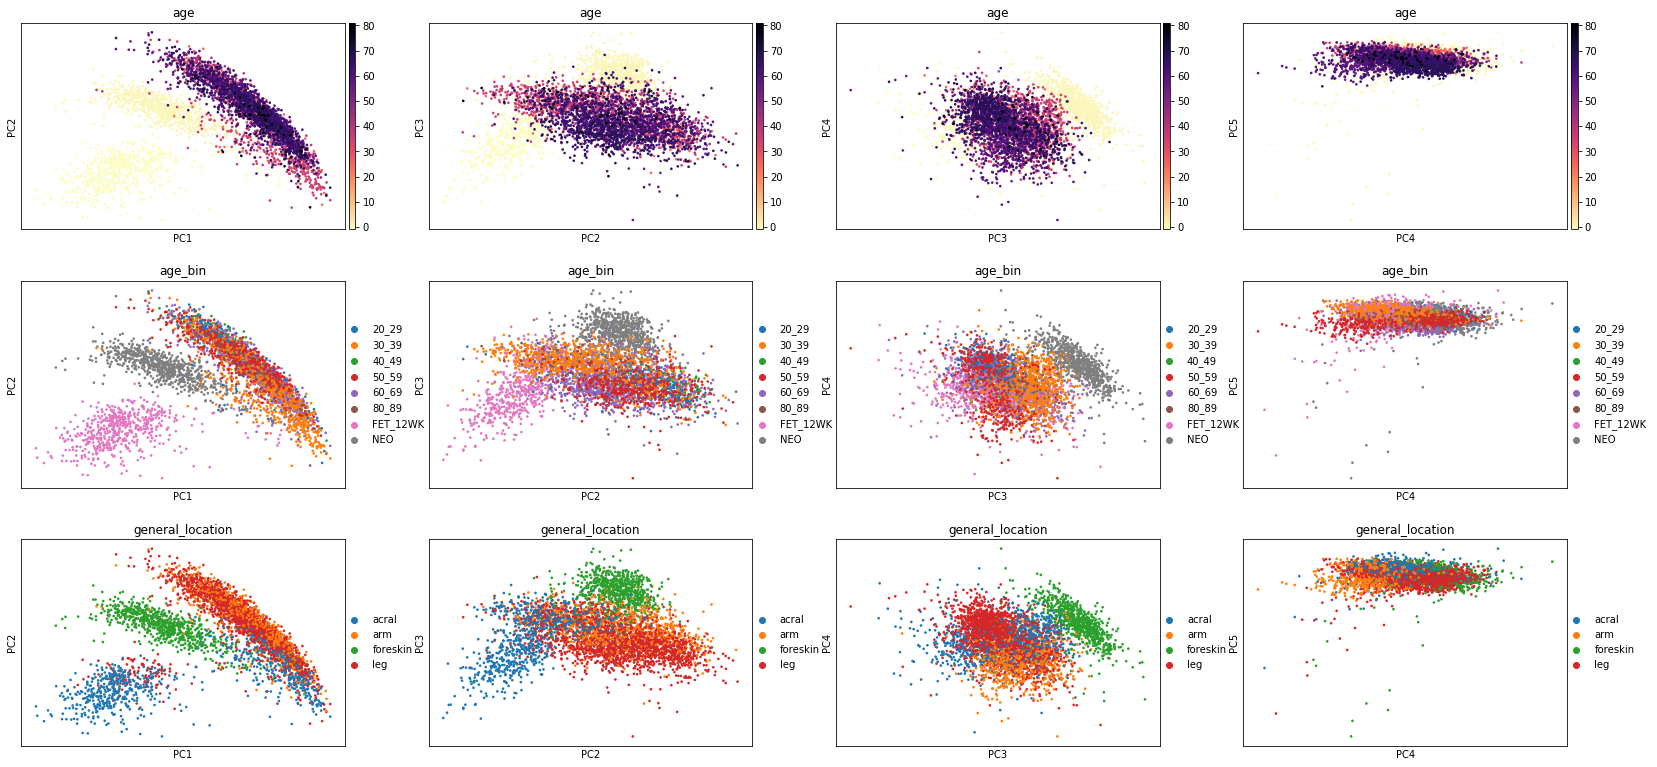

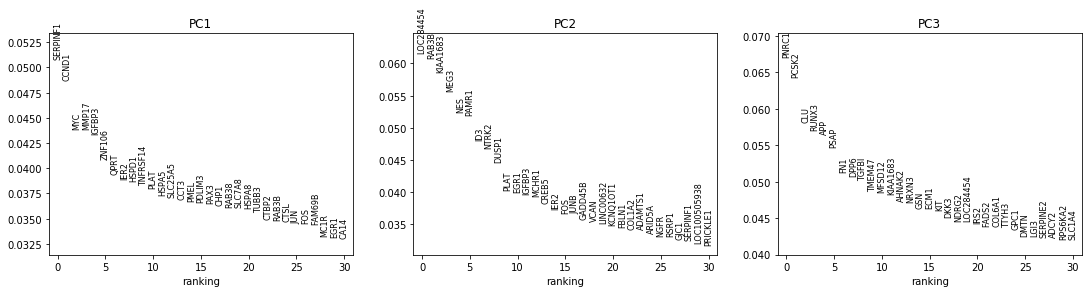

In [9]:
sc.pl.umap(adata_subset2, color=['louvain','age_bin','general_location'], cmap='magma_r')
sc.pl.pca(adata_subset2, components=['1,2','2,3','3,4','4,5'], color=['age','age_bin','general_location'], cmap='magma_r')
sc.pl.pca_loadings(adata_subset2)


In [10]:
# PC2 explains some of the variance in general_location
df = pd.DataFrame({'gene':adata_subset2.var_names,
                   'loading':adata_subset2.varm['PCs'][:,1]})

gene = df.sort_values('loading', ascending=False).head(30).gene
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ' '
[print(x) for x in full_report if search_term in x]


querying 1-30...done.
Finished.
1 input query terms found dup hits:
	[('LINC00632', 2)]
1 input query terms found no hit:
	['KIAA1683']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0: LOC284454
N/A
1: RAB3B
N/A
2: KIAA1683
N/A
3: MEG3
This gene is a maternally expressed imprinted gene. Multiple alternatively spliced transcript variants have been transcribed from this gene and all of them are long non-coding RNAs (lncRNAs). This gene is expressed in many normal tissues, but its expression is lost in multiple cancer cell lines of various tissue origins. It inhibits tumor cell proliferation in vitro. It also interacts with the tumor suppressor p53, and regulates p53 target gene expression. Its deletion enhances angiogenesis in vivo. Many experimental evidences demonstrate that this gene is a lncRNA tumor suppressor. [provided by RefSeq, Mar 2012].
4: NES
This gene encodes a member of the intermediate filament protein family and is expressed primarily

Fibulin 1 is a secreted glycoprotein that becomes incorporated into a fibrillar extracellular matrix. Calcium-binding is apparently required to mediate its binding to laminin and nidogen. It mediates platelet adhesion via binding fibrinogen. Four splice variants which differ in the 3' end have been identified. Each variant encodes a different isoform, but no functional distinctions have been identified among the four variants. [provided by RefSeq, Jul 2008].
23: COL1A2
This gene encodes the pro-alpha2 chain of type I collagen whose triple helix comprises two alpha1 chains and one alpha2 chain. Type I is a fibril-forming collagen found in most connective tissues and is abundant in bone, cornea, dermis and tendon. Mutations in this gene are associated with osteogenesis imperfecta types I-IV, Ehlers-Danlos syndrome type VIIB, recessive Ehlers-Danlos syndrome Classical type, idiopathic osteoporosis, and atypical Marfan syndrome. Symptoms associated with mutations in this gene, however, ten

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Transcriptional noise

In [11]:
# compute txn noise
input_adata = adata_subset2
groupby='patient'
input_adata = txn_noise(input_adata, groupby, pre_adata)



In [12]:
# condense adult group
reclass_dict = {'FET_12WK':'FET_12WK',
                 'NEO':'NEO',
                 '20_29':'20_49',
                 '30_39':'20_49',
                 '40_49':'20_49',
                 '50_59':'50_89',
                 '60_69':'50_89',
                 '80_89':'50_89'}
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_bin']
                                  .map(reclass_dict))
ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_group']
                                  .astype(str)
                                  .astype(CategoricalDtype(ordered_groups, ordered=True)))


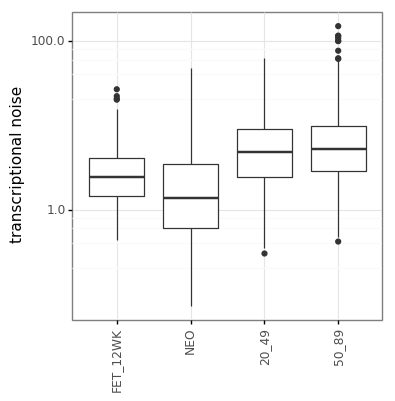

<ggplot: (8769238642198)>
H-test:  786.86379183598 p-value 3.0559012977404997e-170
U-test (50_89 vs NEO):  262938.0 p-value 4.163220702488669e-129


In [13]:
# process for plotting
groupby = 'age_group'
plot_df = (input_adata
           .obs
           .loc[:, [f'{x}' for x in input_adata.obs.columns if x.startswith('noise')] + [groupby]])
plot_df = pd.melt(plot_df, id_vars=groupby)

# plot
plotnine.options.figure_size=(4,4)
print(ggplot(plot_df)
         +theme_bw()
         +theme(axis_text_x=element_text(angle=90))
         +geom_boxplot(aes(groupby,'value'))
         +labs(y='transcriptional noise',x='')
         +scale_y_log10())


# Compute the Kruskal-Wallis H-test for independent samples
groups_dict = {}
for group in list(set(plot_df[groupby])):
    group_vec = plot_df[plot_df[groupby] == group]['value'].dropna().tolist()
    groups_dict[group] = group_vec

eval_list = [f'groups_dict["{i}"]' for i in groups_dict.keys()]
eval_subcmd = ','.join(eval_list)
eval_cmd = f'stats.kruskal({eval_subcmd})'
hstat, pval = eval(eval_cmd)
print('H-test: ', hstat, 'p-value', pval)

# Compute Mann-Whitney U-test for pairwise rank test
group1 = '50_89'
group2 = 'NEO'
ustat, pval = stats.mannwhitneyu(groups_dict[group1],groups_dict[group2])
print(f'U-test ({group1} vs {group2}): ', ustat, 'p-value', pval)

{'A1022M'} 91


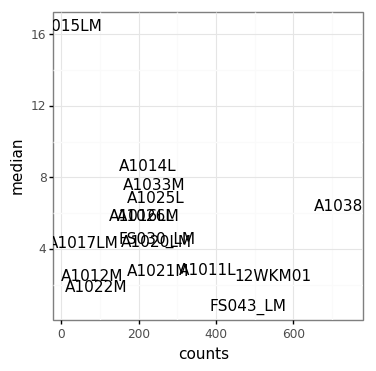

<ggplot: (8769240658629)>


(-0.30119818421923444, 0.2569457938999329)

In [14]:
# determine correlation of noise and # of cells in cohort
## motivation: cohort 40_49 has one patient with relatively low counts
input_adata = adata_subset2
cohortOI = input_adata.obs[input_adata.obs.age_bin == '40_49']
print(set(cohortOI.patient), len(cohortOI))

med_list = []
count_list = []
patient_list = []
for x in set(input_adata.obs.patient):
    df_slice = input_adata.obs.filter(regex=x).dropna()
    count_list.append(len(df_slice))
    med_list.append(df_slice.iloc[:,0].median())
    patient_list.append(x)

plot_df = pd.DataFrame({'median':med_list,
                        'counts':count_list,
                        'patient':patient_list})

print(ggplot(plot_df, aes('counts','median',label='patient'))
      +theme_bw()   
      +geom_text())

# Pearson's correlation => not significant
pearsonr(med_list, count_list)

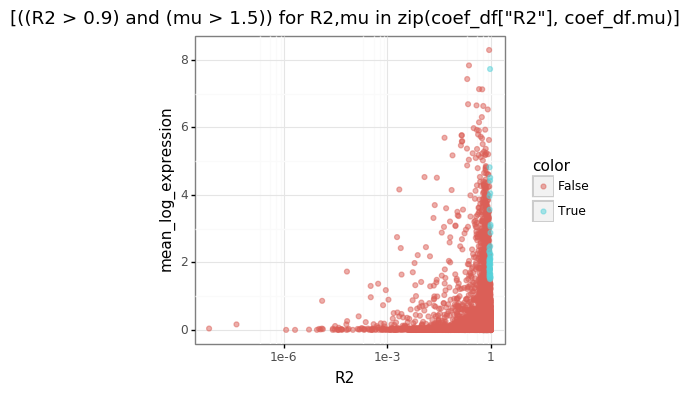

<ggplot: (8769236684278)>


,gene,R,pval,mu,R2,1-R2,color
2652,FAM208A,0.991266,0.008734,1.560237,0.982609,0.017391,True
7359,PRSS23,-0.988443,0.011557,2.222543,0.977020,0.022980,True
6394,NOV,0.988031,0.011969,3.116038,0.976205,0.023795,True
3968,JUN,0.985258,0.014742,3.059902,0.970734,0.029266,True
6246,NDRG2,-0.984521,0.015479,2.880139,0.969283,0.030717,True
1594,CLEC11A,0.983751,0.016249,1.940498,0.967765,0.032235,True
856,C10orf32,0.982128,0.017872,1.650871,0.964575,0.035425,True
3499,HIPK2,0.982086,0.017914,2.108916,0.964492,0.035508,True
9061,TEAD1,0.980502,0.019498,1.526232,0.961384,0.038616,True
9772,USP22,0.977459,0.022541,4.048324,0.955426,0.044574,True


In [15]:
# calculate transcription noise per gene

ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
groupby='age_group'

cat, df = prepare_dataframe(adata_subset2, 
                  var_names=adata_subset2.var_names,
                  groupby=groupby)

# coefficient of variation vs age bin
gene_std = df.groupby(groupby).std()
gene_mean = df.groupby(groupby).mean()
gene_coef = gene_std/gene_mean
gene_coef = gene_coef.reset_index()
gene_coef[groupby] = (gene_coef[groupby]
                      .astype(str)
                      .astype(CategoricalDtype(ordered_groups, ordered=True)))
gene_coef = (gene_coef
             .set_index(groupby)
             .sort_index())

r_list=[]
p_list=[]
mu_list=[]
for x in gene_coef.columns:
    r,p = pearsonr([x for x in range(gene_coef.shape[0])], 
                   gene_coef.loc[:, x])
    r_list.append(r)
    p_list.append(p)
    mu_list.append(df.loc[:,x].mean())
coef_df = pd.DataFrame({'gene':gene_coef.columns,
                         'R':r_list,
                         'pval':p_list,
                       'mu':mu_list})
coef_df['R2'] = coef_df['R']**2
coef_df['1-R2'] = 1-coef_df['R2']
condition_cmd = '[((R2 > 0.9) and (mu > 1.5)) for R2,mu in zip(coef_df["R2"], coef_df.mu)]'
condition_vec = eval(condition_cmd)
coef_df['color'] = condition_vec
coef_df = coef_df.sort_values('pval', ascending=True)
coef_df = coef_df.dropna()

# plot and print 
print(ggplot(coef_df)
      +theme_bw()
      +geom_point(aes('R2','mu', color = 'color'), alpha = 0.5)
      +scale_x_log10()
      +ggtitle(condition_cmd)
      +labs(y = 'mean_log_expression'))

coef_df[coef_df.color == True]

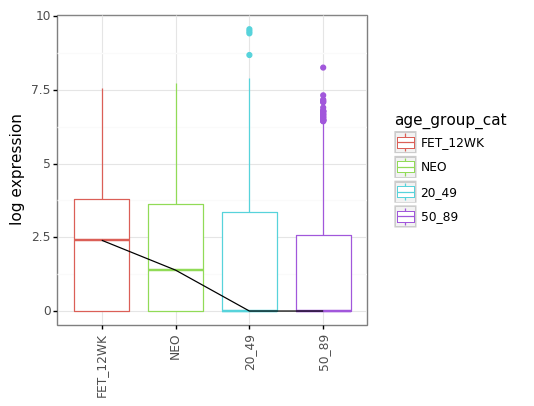

<ggplot: (8769241014455)>


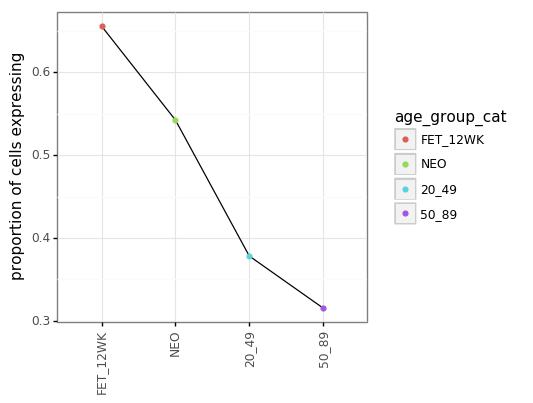

<ggplot: (8769240974333)>


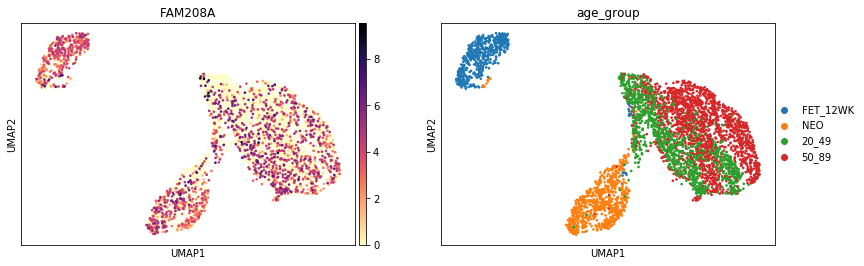

querying 1-1...done.
Finished.
1 input query terms found no hit:
	['FAM208A']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
0:  FAM208A 
 N/A
age_group
FET_12WK    0.869946
NEO         1.092594
20_49       1.462846
50_89       1.639484
Name: FAM208A, dtype: float32


In [16]:
# plot expression
gene = 'FAM208A'
input_adata = adata_subset2
groupby='age_group'
ordered_list = ordered_groups

gene2plots(input_adata, gene, groupby, ordered_list)
sc.pl.umap(input_adata, color=[gene, 'age_group'], cmap='magma_r')
out = symbol2field(gene)
[print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]

try: 
    print(gene_coef.loc[:,gene])
except:
    print('no txn noise data')


In [ ]:
# look up gene function and search for keywords
gene = coef_df[coef_df.color == True].gene
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ' '
[print(x) for x in full_report if search_term in x]

In [ ]:
# create coarse age_groups
reclass_dict = {'FET_12WK':'FET_12WK',
                 'NEO':'NEO',
                 '20_29':'20_49',
                 '30_39':'20_49',
                 '40_49':'20_49',
                 '50_59':'50_89',
                 '60_69':'50_89',
                 '80_89':'50_89'}
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_bin']
                                  .map(reclass_dict))
ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
adata_subset2.obs['age_group'] = (adata_subset2
                                  .obs['age_group']
                                  .astype(str)
                                  .astype(CategoricalDtype(ordered_groups, ordered=True)))


In [ ]:
# mhcI gene set, ref: http://software.broadinstitute.org/gsea/msigdb/cards/GO_MHC_CLASS_I_PROTEIN_COMPLEX.html
input_adata = adata_subset2

geneset = pd.read_csv('s3://daniel.le-work/MEL_project/mhcI_genes.txt',
           delimiter = '\t', usecols=[1], header=None)
geneset.columns = ['gene']
geneset = [x for x in geneset.gene if x in input_adata.var_names]
print(geneset)

ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
groupby='age_group'

cats, casted_df = prepare_dataframe(input_adata, 
                                         geneset, 
                                         groupby=groupby)

melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)
melt_df[f'{groupby}_cat'] = melt_df[groupby].astype(str).astype(CategoricalDtype(ordered_groups, ordered=True))

plot_df = pd.DataFrame(melt_df.groupby(['age_group_cat','variable']).mean().to_records())
plot_df['age_group_cat'] = plot_df['age_group_cat'].astype(str).astype(CategoricalDtype(ordered_groups,ordered=True))

print(ggplot(plot_df)
     +theme_bw()
     +geom_line(aes('age_group_cat','value', group='variable', color='variable'))
     +labs(x='age_group',y='mean log expression'))

In [ ]:
# spliceosome gene set, ref: http://software.broadinstitute.org/gsea/msigdb/cards/SPLICEOSOME.html
input_adata = adata_subset2

geneset = pd.read_csv('s3://daniel.le-work/MEL_project/spliceosome_genes.txt',
           delimiter = '\t', usecols=[1], header=None)
geneset.columns = ['gene']
geneset = [x for x in geneset.gene if x in input_adata.var_names]
print(geneset)

ordered_groups = ['FET_12WK',
                 'NEO',
                 '20_49',
                 '50_89']
groupby='age_group'

cats, casted_df = prepare_dataframe(input_adata, 
                                         geneset, 
                                         groupby=groupby)

melt_df = pd.melt(casted_df.reset_index(), id_vars=groupby)
melt_df[f'{groupby}_cat'] = melt_df[groupby].astype(str).astype(CategoricalDtype(ordered_groups, ordered=True))

plot_df = pd.DataFrame(melt_df.groupby(['age_group_cat','variable']).mean().to_records())
plot_df['age_group_cat'] = plot_df['age_group_cat'].astype(str).astype(CategoricalDtype(ordered_groups,ordered=True))

print(ggplot(plot_df)
     +theme_bw()
     +geom_line(aes('age_group_cat','value', group='variable', color='variable'))
     +labs(x='age_group',y='mean log expression'))


# DE genes: outliers vs rest

In [ ]:
input_adata = adata_subset1
groupby='outliers'
prefix='AllMel_aging_outliers'

full_df, joint_df = rank_push (input_adata, groupby, prefix, wkdir, s3dir)

# DE genes: age bin vs rest

In [ ]:
input_adata = adata_subset2
groupby='age_bin'
prefix='AllMel_aging'

full_df, joint_df = rank_push (input_adata, groupby, prefix, wkdir, s3dir)


# Gene and age correlation

In [ ]:
ref = 'age'
corr_age = pd.DataFrame(input_adata.X)
corr_age.columns = input_adata.var_names
corr_age[ref] = input_adata.obs[ref].tolist()

df = corr_age.dropna()._get_numeric_data()
r_list = []
p_list = []
gene_list = []
for col in df.columns.tolist():
    r, pval = pearsonr(df[ref], df[col])
    r_list.append(r)
    p_list.append(pval)
    gene_list.append(col)
out_df = pd.DataFrame({'gene':gene_list,
                       'R':r_list, 
                       'pval':p_list})
out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
out_df['R2'] = out_df['R']**2 
out_df = out_df.sort_values('R2', ascending=False)
out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
print(out_df.head(20))

plotnine.options.figure_size=(4,4)
print(ggplot(out_df)
          +theme_bw()
          +geom_point(aes('R','pval'))
          +scale_y_log10()
          +labs(x='Pearsons R', y='p-value'))

# # Top negatively correlated genes
# print('Top negatively correlated genes')
# sc.pl.umap(adata_subset2, color=['age_bin','SERPINF1','CCND1','MYC','IGFBP3','MAL','S100B','QPRT'], cmap='magma_r')

# # Top positively correlated genes
# print('Top positively correlated genes')
# sc.pl.umap(adata_subset2, color=['age_bin','CRABP1','CLU','S100A6','HLA-B','HLA-C','APOD','B2M'], cmap='magma_r')

# # Canonical MEL genes
# print('Canonical MEL genes')
# sc.pl.umap(adata_subset2, color=['age_bin','PMEL','TYR','MITF','TYRP1','MLANA','DCT','KIT'], cmap='magma_r')

# DEV

In [ ]:
# determine what additional patient samples to prioritize
# adata_subset2.obs.groupby(['age_bin','race']).count()
(adata_subset2
 .obs
 .loc[:,['age_bin','color','patient']]
 .groupby(['age_bin','color'])
 .nunique())

In [ ]:
# look for age correlation in adt MELs

run = False
if run is True:

    feature_dict = {'class_1':['MEL'],
                    'class_2':['in'],
                    'age_bin':['20_29','30_39','40_49','50_59','60_69','80_89']}
    adata_subset3 = subset_adata_v3(raw_adata,feature_dict)
    adata_subset3 = process_adata(adata_subset3)
    pca_adata(adata_subset3, num_pcs=30)
    umap_adata(adata_subset3, res=0.2)

    # correlation to age
    input_adata=adata_subset3

    ref = 'age'
    corr_age = pd.DataFrame(input_adata.X)
    corr_age.columns = input_adata.var_names
    corr_age[ref] = input_adata.obs[ref].tolist()

    df = corr_age.dropna()._get_numeric_data()
    r_list = []
    p_list = []
    gene_list = []
    for col in df.columns.tolist():
        r, pval = pearsonr(df[ref], df[col])
        r_list.append(r)
        p_list.append(pval)
        gene_list.append(col)
    out_df = pd.DataFrame({'gene':gene_list,
                           'R':r_list, 
                           'pval':p_list})
    out_df = out_df.iloc[[x != ref for x in out_df['gene']],:]
    out_df['R2'] = out_df['R']**2 
    out_df = out_df.sort_values('R2', ascending=False)
    out_df['pval'] = out_df['pval'].replace(0, min([x for x in out_df['pval'] if x>0]))
    print(out_df.head(20))

    plotnine.options.figure_size=(4,4)
    print(ggplot(out_df)
              +theme_bw()
              +geom_point(aes('R','pval'))
              +scale_y_log10()
              +labs(x='Pearsons R', y='p-value'))

### Conclusion: weak correlation between age and expression in adt MEL

In [ ]:
# find coherent gene sets by clustering gene-cell counts table
## try this: https://www.biorxiv.org/content/biorxiv/early/2018/07/11/367003.full.pdf

# output necessary input cell/gene counts table
## format: ENSEMBL_ID  GENE_NAME  UMICOUNT_CELL0  UMICOUNT_CELL1 ...
## no header
## only MEL cells and raw counts
dense_mels = pd.DataFrame(np.exp(adata_subset2.raw.X.todense().T).astype(int)-1)
dense_mels = pd.concat([pd.DataFrame({'gene':adata_subset2.raw.var_names}),dense_mels],axis=1)
 
(dense_mels
 .to_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190102_schpf_input.txt', 
        header=False,
        sep=' '))

# read in gene scoeres from scHPF
input_param = '21x5'

gene_score = pd.read_csv(f'/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf_report_{input_param}.gene_score.txt',
           header=None,
           delimiter='\t')

gene_df = pd.concat([(pd.read_csv('/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf.genes.txt',
           header=None,
           delimiter='\t')
            .iloc[:,1]),
           gene_score], axis=1)
gene_df.columns = ['gene'] + [f'factor_{x}' for x in range(gene_score.shape[1])]

cell_scores = pd.read_csv(f'/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf_report_{input_param}.cell_score.txt',
               header=None,
               delimiter='\t')
cell_scores.columns = [f'cell_score_{x}' for x in range(cell_scores.shape[1])]

for col in cell_scores.columns:
    adata_subset2.obs[col] = cell_scores.loc[:,col].values

sc.pl.umap(adata_subset2, color=['age','age_bin']+cell_scores.columns.tolist(), cmap='magma_r')

geneset = 'gene_rank_4'

ranked_genes = pd.read_csv(f'/home/ubuntu/data/DL20181011_melanocyte_test_data/schpf_report_{input_param}.ranked_genes.txt',
           header=None,
           delimiter='\t')

ranked_genes.columns = [f'gene_rank_{x}' for x in range(ranked_genes.shape[1])]

genelist = ranked_genes.loc[:,geneset].values.tolist()[-30:]
sc.pl.umap(adata_subset2, color=genelist, cmap='magma_r')
out = symbol2field(genelist)
[print(x['query'],'\n',x['summary']) if ('summary' in x.keys()) else print(x['query'],'\n','N/A') for x in out]


In [ ]:
# create df for s3 pull
new_plates = ['B000771', 
             'B001440', 
             'B001439', 
             'B001438', 
             'B001429', 
             'B003346']
old_plates = list(set([x.split('_')[1] for x in pre_adata.columns]))
all_plates = new_plates + old_plates
plate_list = all_plates

plate_dfs = s3_crawler(plate_list, s3dir_df, manual_filter=True)



In [ ]:
# pull s3 file system structure
paths = ['s3://daniel.le-work/MEL_project/DL20190114_czbseqbot.txt',
         's3://daniel.le-work/MEL_project/DL20190114_czbiohubseqbot.txt',
         's3://daniel.le-work/MEL_project/DL20190114_darmanis.txt']
s3dir_df = pd.read_csv(paths[0], header=None)
for path in paths[1:]:
    s3dir_df_append = pd.read_csv(path, header=None)
    s3dir_df = s3dir_df.append(s3dir_df_append)
s3dir_df.columns = ['paths']
s3dir_df = s3dir_df[['homo.htseq-count.txt' in x for x in s3dir_df.paths]]



In [ ]:
# pull from s3
import multiprocessing
num_cores = multiprocessing.cpu_count()
nb_cpus = num_cores-1

wkdir = '/home/ubuntu/data/DL20181011_melanocyte_test_data'
pool = multiprocessing.Pool(processes=nb_cpus)
results = pool.map(pulls3, zip(plate_dfs.paths, 
                               plate_dfs.plate,
                               plate_dfs.fname,
                               [wkdir]*len(plate_dfs)))


In [ ]:
# compile from local dfs and push to s3
top_dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data/tmp/'
big_df = merge_counts(top_dir)
local_file = '/home/ubuntu/data/DL20181011_melanocyte_test_data/DL20190115_big_counts.txt'
big_df.to_csv(local_file)
cmd = f'aws s3 cp {local_file} s3://daniel.le-work/MEL_project/'
subprocess.run(cmd.split(' '))

# delete tmp when done